In [287]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

large_models_df = pd.read_csv("large_scale_ai_models.csv")
notable_models_df = pd.read_csv("notable_ai_models.csv")
cooling_df = pd.read_csv("cooling_type_data.csv")
carbon_df = pd.read_csv("carbon_intensity_electricity.csv")
chip_df = pd.read_csv("chip_dataset.csv")

large_models_df['Publication date'] = pd.to_datetime(large_models_df['Publication date'], errors='coerce')
large_models_df['Year'] = large_models_df['Publication date'].dt.year
large_models_df['Training compute (FLOP)'] = pd.to_numeric(large_models_df['Training compute (FLOP)'], errors='coerce')
large_models_df = large_models_df.dropna(subset=['Year', 'Training compute (FLOP)'])

top_large_models = large_models_df.sort_values('Training compute (FLOP)', ascending=False).drop_duplicates(subset=['Year'])
top_large_models = top_large_models[['Model', 'Year', 'Training compute (FLOP)', 'Training hardware']].copy()
top_large_models['Model (Year)'] = top_large_models['Model'] + " (" + top_large_models['Year'].astype(str) + ")"
top_large_models['key'] = 1

cooling_df = cooling_df.drop_duplicates(subset=['Cooling System']).copy()
cooling_df = cooling_df[cooling_df['Size'] == 'Large-scale'].copy()
cooling_df['key'] = 1

combined = pd.merge(top_large_models, cooling_df, on='key').drop(columns='key')

chip_df['Release Date'] = pd.to_datetime(chip_df['Release Date'], format="%m/%d/%y", errors='coerce')
chip_df['Year'] = chip_df['Release Date'].dt.year
chip_df['FP32 GFLOPS'] = pd.to_numeric(chip_df['FP32 GFLOPS'], errors='coerce')
chip_df['TDP (W)'] = pd.to_numeric(chip_df['TDP (W)'], errors='coerce')


In [288]:
unique_models = top_large_models['Model (Year)'].dropna().unique()
palette = sns.color_palette("tab10", n_colors=len(unique_models))
model_color_map = dict(zip(unique_models, palette))

top_large_models

,Model,Year,Training compute (FLOP),Training hardware,Model (Year),key
21,Grok-3,2025,4.640000e+26,NVIDIA H100 SXM5 80GB,Grok-3 (2025),1
167,Gemini 1.0 Ultra,2023,5.000000e+25,Google TPU v4,Gemini 1.0 Ultra (2023),1
100,GPT-4o,2024,3.810001e+25,NaN,GPT-4o (2024),1
271,GPT-3.5,2022,2.578000e+24,NVIDIA A100 SXM4 40 GB,GPT-3.5 (2022),1
299,EXAONE 1.0,2021,1.695600e+24,NaN,EXAONE 1.0 (2021),1
310,AlphaGo Zero,2017,3.410000e+23,Google TPU v1,AlphaGo Zero (2017),1
307,GPT-3 175B (davinci),2020,3.140000e+23,NVIDIA Tesla V100 DGXS 32 GB,GPT-3 175B (davinci) (2020),1


In [ ]:
def find_chip_info(hardware: str, year: int, df: pd.DataFrame):
    df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')
    df['FP32 GFLOPS'] = pd.to_numeric(df['FP32 GFLOPS'], errors='coerce')
    df['TDP (W)'] = pd.to_numeric(df['TDP (W)'], errors='coerce')

    if isinstance(hardware, str):
        matched = df[df['Product'].str.lower() == hardware.lower()]
        if not matched.empty and pd.notna(matched.iloc[0]['FP32 GFLOPS']):
            return matched.iloc[0]['FP32 GFLOPS'], matched.iloc[0]['TDP (W)']

    # Fallback to best chip in year
    chips_year = df[df['Release Date'].dt.year == year]
    chips_year = chips_year.dropna(subset=['FP32 GFLOPS'])
    if not chips_year.empty:
        best_chip = chips_year.loc[chips_year['FP32 GFLOPS'].idxmax()]
        return best_chip['FP32 GFLOPS'], best_chip['TDP (W)']

    return None, None


In [290]:
results = []
for _, row in top_large_models.iterrows():
    model = row['Model']
    year = row['Year']
    hardware = row['Training hardware']
    flop = row['Training compute (FLOP)']
    fp32_flops, tdp = find_chip_info(hardware, year + 1, chip_df)

    results.append({
        'Model': model,
        'Year': year,
        'Training hardware': hardware,
        'Training compute (FLOP)' : flop,
        'FP32 GFLOPS': fp32_flops,
        'TDP (W)': tdp
    })

final_top_models = pd.DataFrame(results)

final_top_models['Energy (J)'] = (final_top_models['TDP (W)'] / (final_top_models['FP32 GFLOPS'] * 10**9)) * final_top_models['Training compute (FLOP)']
final_top_models


,Model,Year,Training hardware,Training compute (FLOP),FP32 GFLOPS,TDP (W),Energy (J)
0,Grok-3,2025,NVIDIA H100 SXM5 80GB,4.640000e+26,NaN,NaN,NaN
1,Gemini 1.0 Ultra,2023,Google TPU v4,5.000000e+25,71810.0,285.0,1.984403e+14
2,GPT-4o,2024,NaN,3.810001e+25,NaN,NaN,NaN
3,GPT-3.5,2022,NVIDIA A100 SXM4 40 GB,2.578000e+24,19490.0,400.0,5.290918e+13
4,EXAONE 1.0,2021,NaN,1.695600e+24,91610.0,300.0,5.552669e+12
5,AlphaGo Zero,2017,Google TPU v1,3.410000e+23,16660.0,250.0,5.117047e+12
6,GPT-3 175B (davinci),2020,NVIDIA Tesla V100 DGXS 32 GB,3.140000e+23,15670.0,250.0,5.009572e+12


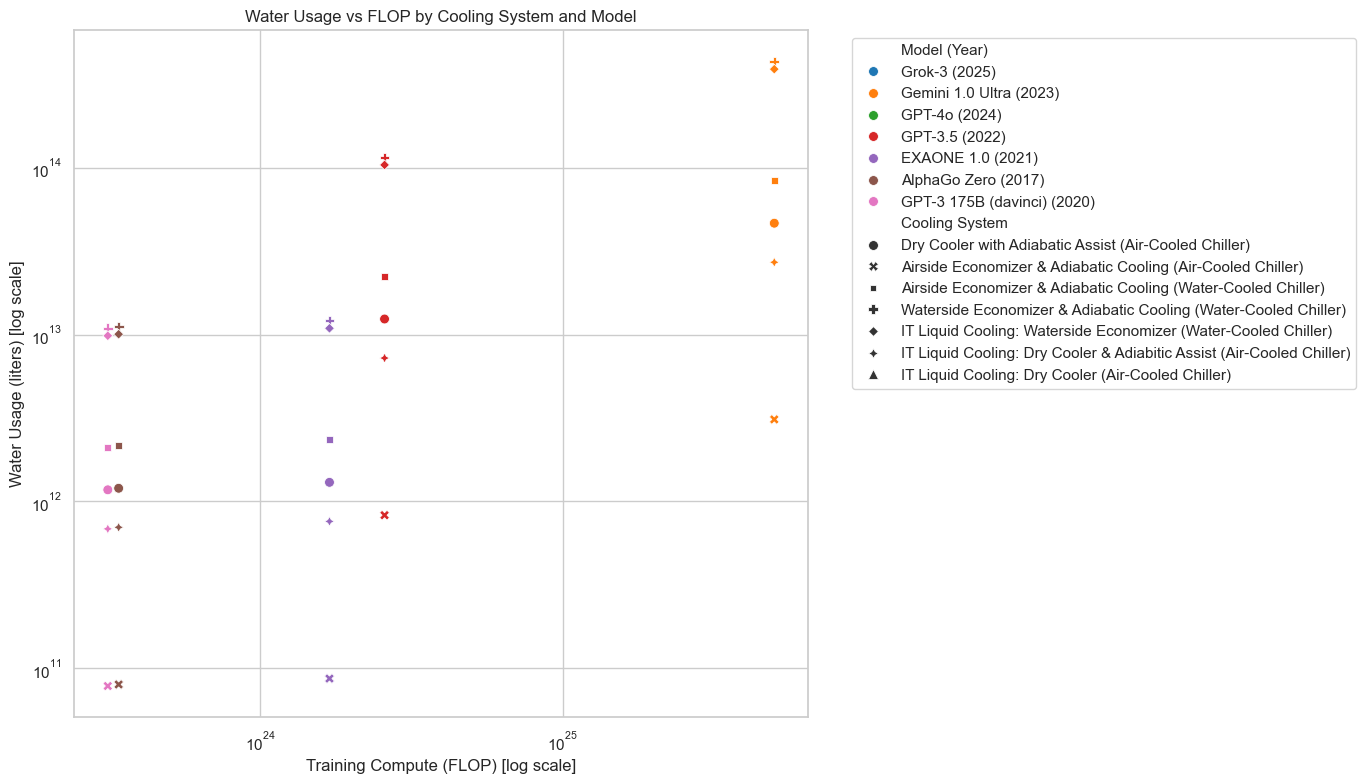

In [291]:
combined = combined.merge(
    final_top_models[['Model', 'Energy (J)']],
    on='Model',
    how='left'
)

combined['Water Usage'] = combined['AvgWUE'] * combined['Energy (J)']

unique_models = top_large_models['Model (Year)'].dropna().unique()
palette = sns.color_palette("tab10", n_colors=len(unique_models))
model_color_map = dict(zip(unique_models, palette))

plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

plot = sns.scatterplot(
    data=combined,
    x='Training compute (FLOP)',
    y='Water Usage',
    hue='Model (Year)',
    style='Cooling System',
    palette=model_color_map,
    s=50
)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Training Compute (FLOP) [log scale]')
plt.ylabel('Water Usage (liters) [log scale]')
plt.title('Water Usage vs FLOP by Cooling System and Model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [292]:
combined['Cooling System Energy (J)'] = combined['Energy (J)'] * (combined['AvgPUE'] - 1)
combined['Total Energy (J)'] = combined['Energy (J)'] + combined['Cooling System Energy (J)']

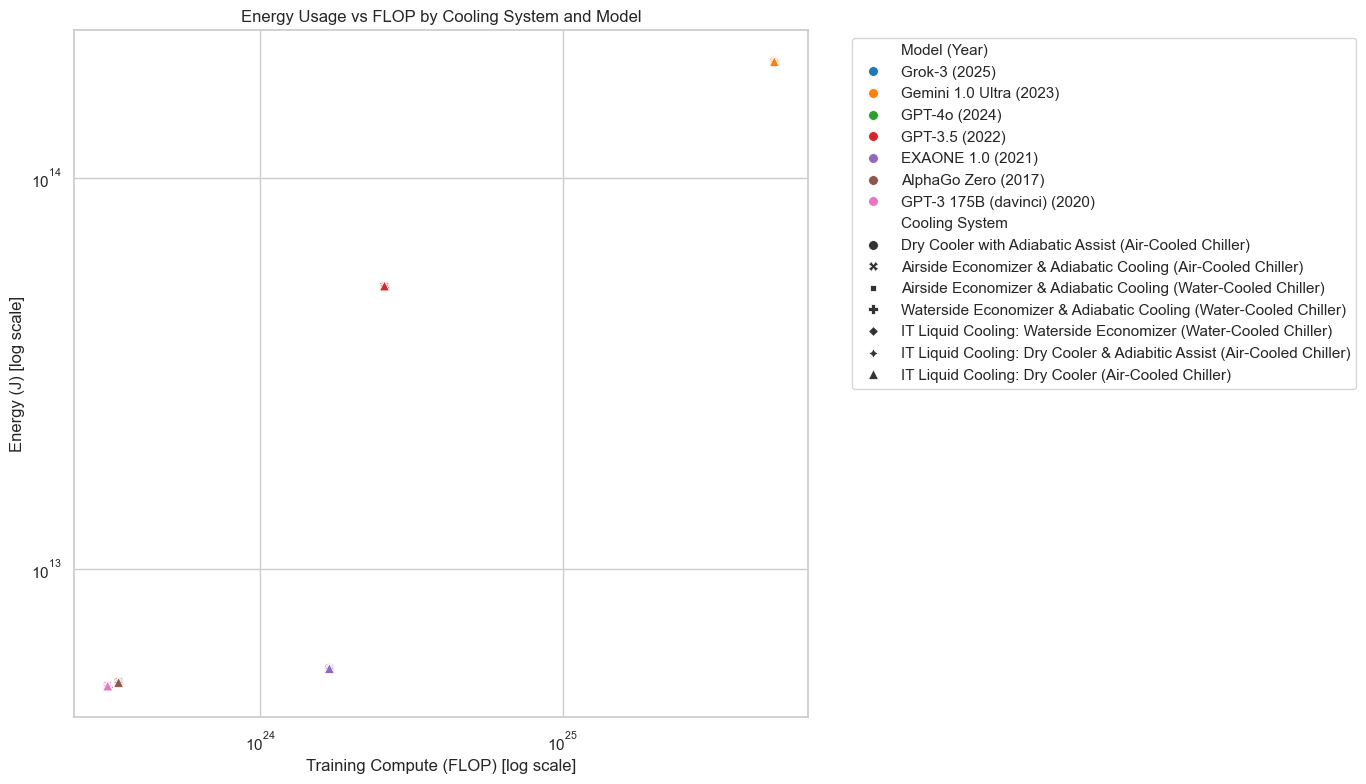

In [293]:
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

plot = sns.scatterplot(
    data=combined,
    x='Training compute (FLOP)',
    y='Energy (J)',
    hue='Model (Year)',
    style='Cooling System',
    palette=model_color_map,
    s=50
)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Training Compute (FLOP) [log scale]')
plt.ylabel('Energy (J) [log scale]')
plt.title('Energy Usage vs FLOP by Cooling System and Model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

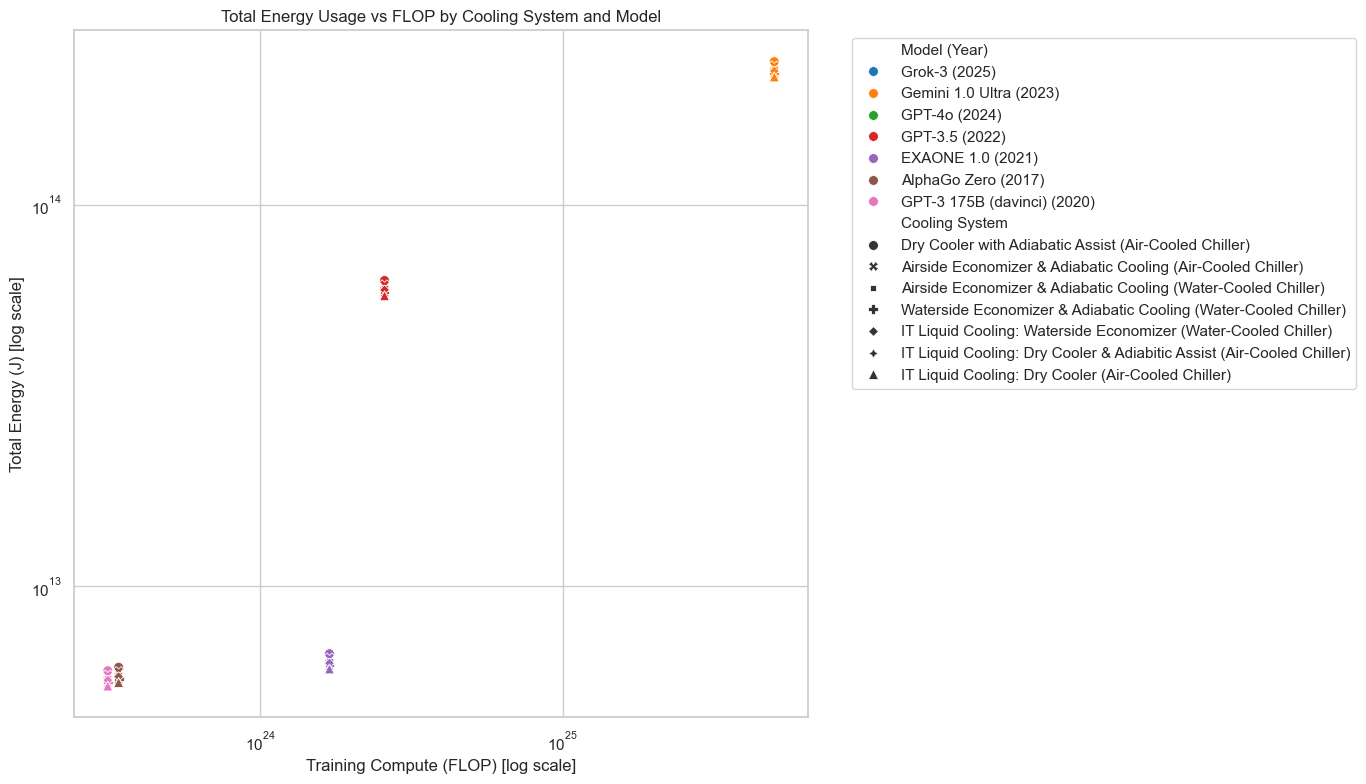

In [294]:
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

plot = sns.scatterplot(
    data=combined,
    x='Training compute (FLOP)',
    y='Total Energy (J)',
    hue='Model (Year)',
    style='Cooling System',
    palette=model_color_map,
    s=50
)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Training Compute (FLOP) [log scale]')
plt.ylabel('Total Energy (J) [log scale]')
plt.title('Total Energy Usage vs FLOP by Cooling System and Model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [295]:
combined['Energy (kWh)'] = combined['Energy (J)'] / (3.6e6)  # Convert Joules to kWh
combined['Cooling System Energy (kWh)'] = combined['Cooling System Energy (J)'] / (3.6e6)  # Convert Joules to kWh
combined['Total Energy (kWh)'] = combined['Total Energy (J)'] / (3.6e6)  # Convert Joules to kWh

carbon_df = carbon_df.rename(columns={'Carbon intensity of electricity - gCO2/kWh': 'Carbon Intensity (kg CO2 per kWh)'})
carbon_df['Carbon Intensity (kg CO2 per kWh)'] = carbon_df['Carbon Intensity (kg CO2 per kWh)'] / 1000
carbon_df_usa = carbon_df[carbon_df['Entity'] == 'United States'].copy()

combined = pd.merge(combined, carbon_df_usa[['Year', 'Carbon Intensity (kg CO2 per kWh)']], on='Year', how='left')

combined['Carbon Impact (kg CO2)'] = combined['Energy (kWh)'] * combined['Carbon Intensity (kg CO2 per kWh)']
combined['Cooling System Carbon Impact (kg CO2)'] = combined['Cooling System Energy (kWh)'] * combined['Carbon Intensity (kg CO2 per kWh)']
combined['Total Carbon Impact (kg CO2)'] = combined['Total Energy (kWh)'] * combined['Carbon Intensity (kg CO2 per kWh)']

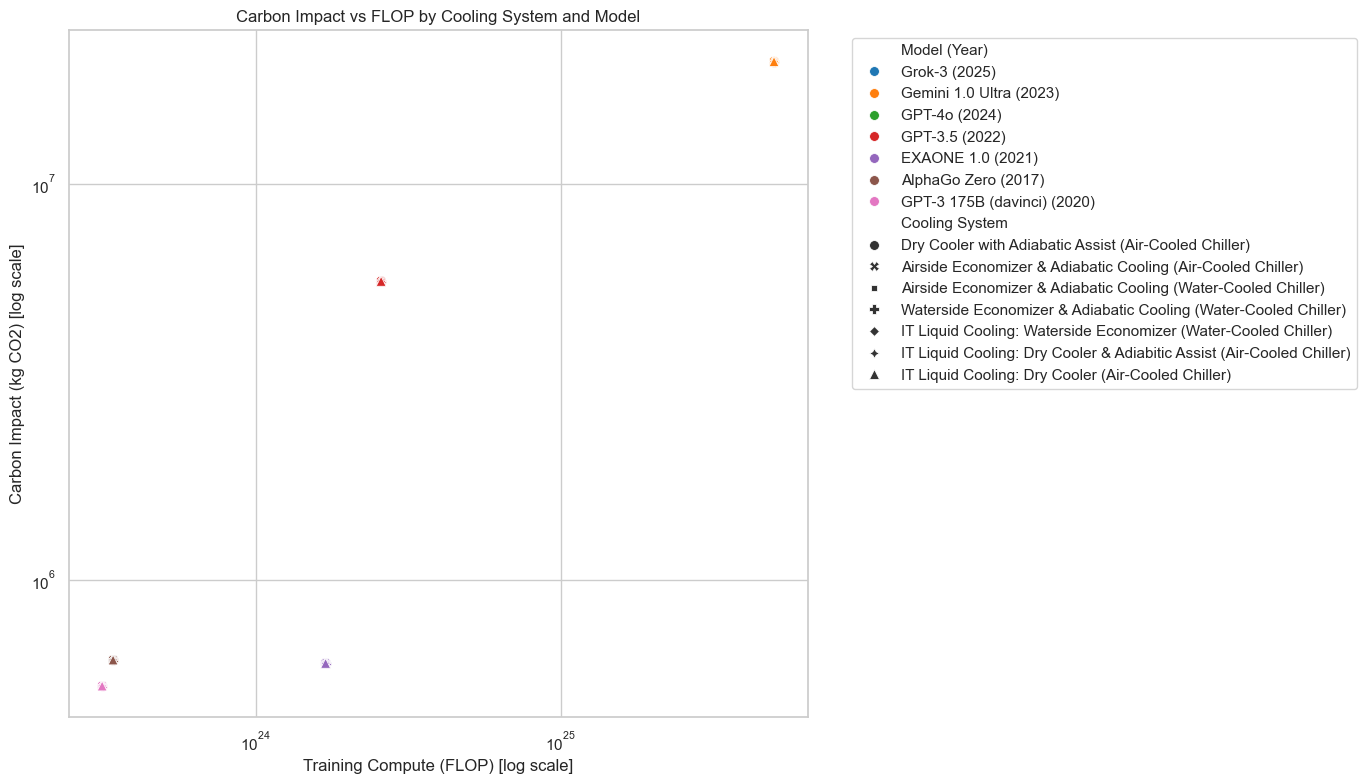

In [296]:
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

plot = sns.scatterplot(
    data=combined,
    x='Training compute (FLOP)',
    y='Carbon Impact (kg CO2)',
    hue='Model (Year)',
    style='Cooling System',
    palette=model_color_map,
    s=50,
)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Training Compute (FLOP) [log scale]')
plt.ylabel('Carbon Impact (kg CO2) [log scale]')
plt.title('Carbon Impact vs FLOP by Cooling System and Model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

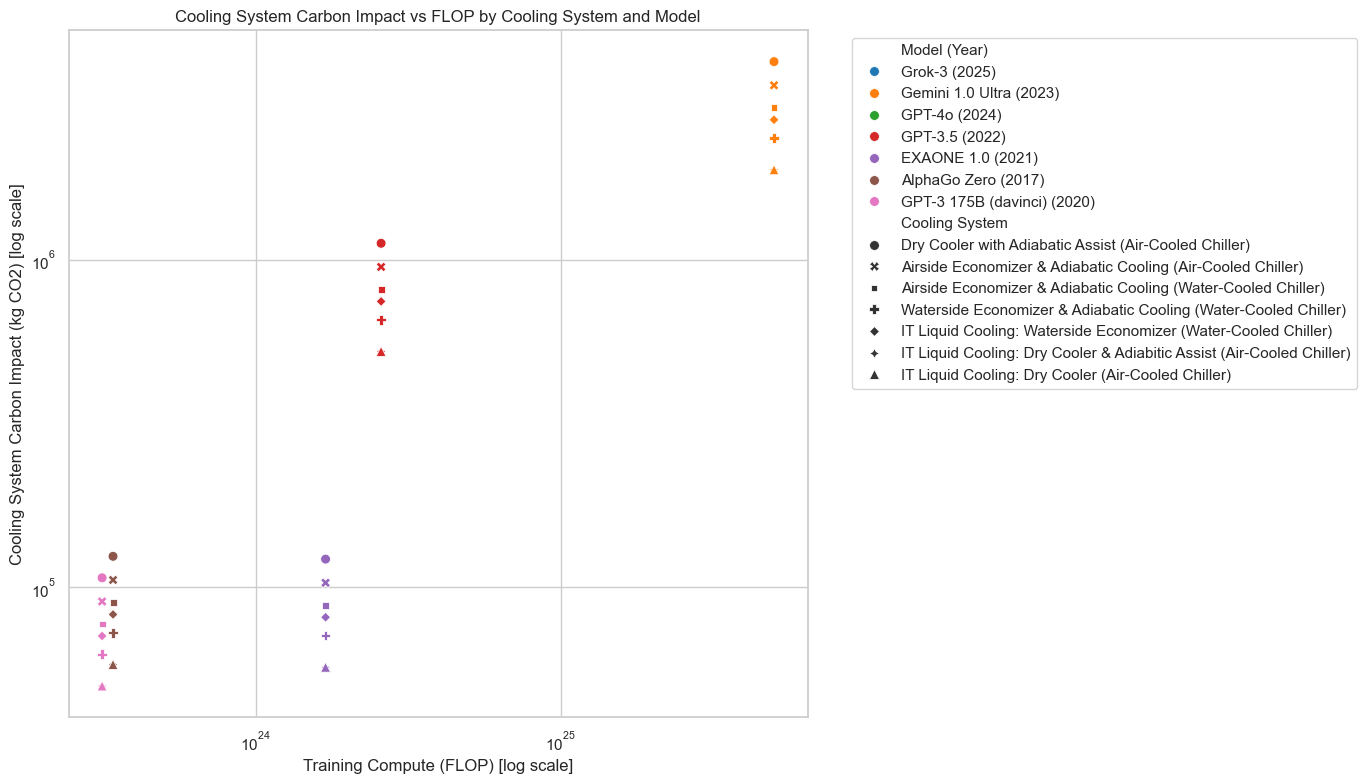

In [297]:
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

plot = sns.scatterplot(
    data=combined,
    x='Training compute (FLOP)',
    y='Cooling System Carbon Impact (kg CO2)',
    hue='Model (Year)',
    style='Cooling System',
    palette=model_color_map,
    s=50,
)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Training Compute (FLOP) [log scale]')
plt.ylabel('Cooling System Carbon Impact (kg CO2) [log scale]')
plt.title('Cooling System Carbon Impact vs FLOP by Cooling System and Model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

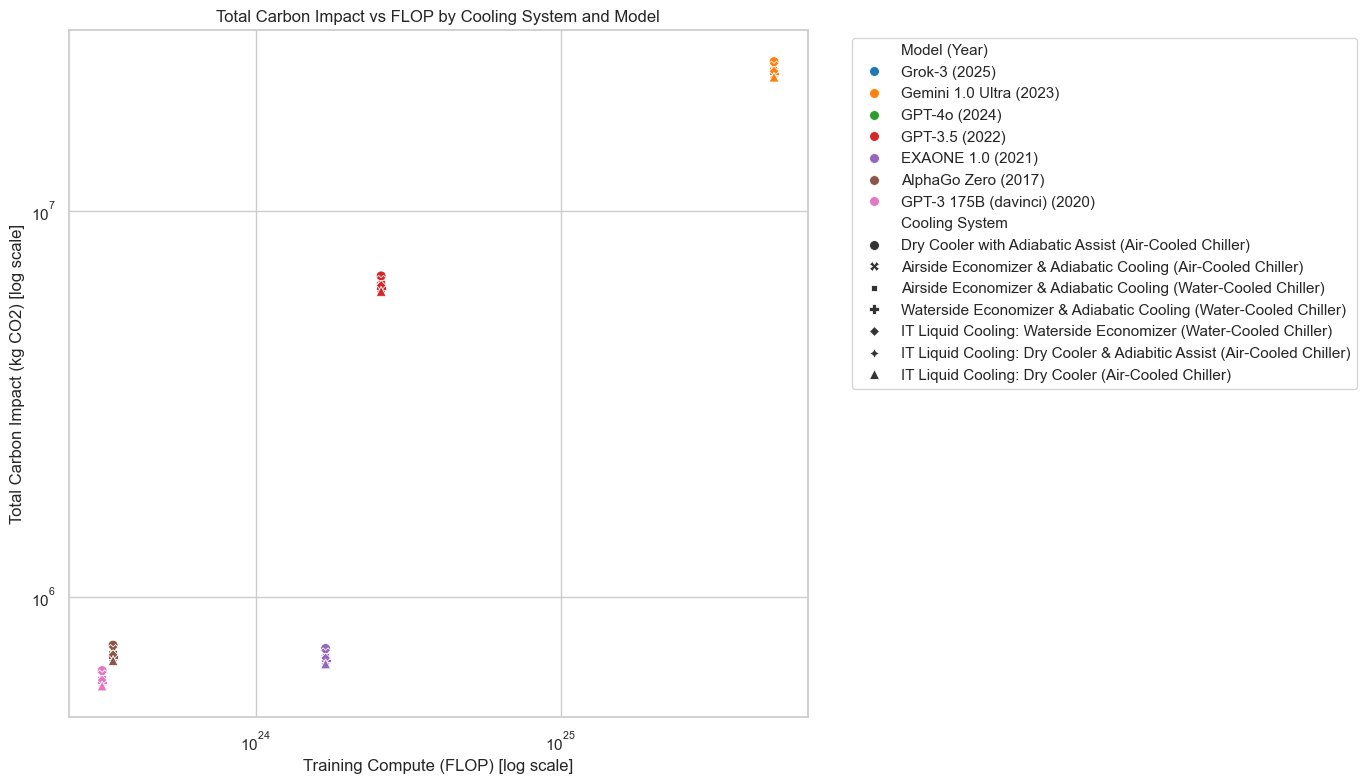

In [298]:
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

plot = sns.scatterplot(
    data=combined,
    x='Training compute (FLOP)',
    y='Total Carbon Impact (kg CO2)',
    hue='Model (Year)',
    style='Cooling System',
    palette=model_color_map,
    s=50,
)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Training Compute (FLOP) [log scale]')
plt.ylabel('Total Carbon Impact (kg CO2) [log scale]')
plt.title('Total Carbon Impact vs FLOP by Cooling System and Model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [299]:
notable_models_df['Publication date'] = pd.to_datetime(notable_models_df['Publication date'], errors='coerce')
notable_models_df['Year'] = notable_models_df['Publication date'].dt.year
notable_models_df['Training compute (FLOP)'] = pd.to_numeric(notable_models_df['Training compute (FLOP)'], errors='coerce')
notable_models_df = notable_models_df.dropna(subset=['Year', 'Training compute (FLOP)'])

notable_models_df = notable_models_df[notable_models_df['Year'].between(2015, 2025)]

top_notable_models = notable_models_df.sort_values('Training compute (FLOP)', ascending=False).drop_duplicates(subset=['Year'])
top_notable_models = top_notable_models[['Model', 'Year', 'Training compute (FLOP)', 'Training hardware']].copy()
top_notable_models['Model (Year)'] = top_notable_models['Model'] + " (" + top_notable_models['Year'].astype(str) + ")"
top_notable_models['key'] = 1

combined_notable = pd.merge(top_notable_models, cooling_df, on='key').drop(columns='key')

unique_models = top_notable_models['Model (Year)'].dropna().unique()
palette = sns.color_palette("tab10", n_colors=len(unique_models))
model_color_map = dict(zip(unique_models, palette))

In [300]:
results = []
for _, row in top_notable_models.iterrows():
    model = row['Model']
    year = row['Year']
    hardware = row['Training hardware']
    flop = row['Training compute (FLOP)']
    fp32_flops, tdp = find_chip_info(hardware, year + 1, chip_df)

    results.append({
        'Model': model,
        'Year': year,
        'Training hardware': hardware,
        'Training compute (FLOP)' : flop,
        'FP32 GFLOPS': fp32_flops,
        'TDP (W)': tdp
    })

final_notable_models = pd.DataFrame(results)

final_notable_models['Energy (J)'] = (final_notable_models['TDP (W)'] / (final_notable_models['FP32 GFLOPS'] * 10**9)) * final_notable_models['Training compute (FLOP)']
final_notable_models

,Model,Year,Training hardware,Training compute (FLOP),FP32 GFLOPS,TDP (W),Energy (J)
0,Grok-3,2025,NVIDIA H100 SXM5 80GB,4.640000e+26,NaN,NaN,NaN
1,Gemini 1.0 Ultra,2023,Google TPU v4,5.000000e+25,71810.0,285.0,1.984403e+14
2,GPT-4o,2024,NaN,3.810001e+25,NaN,NaN,NaN
3,Minerva (540B),2022,Google TPU v4,2.741500e+24,81720.0,750.0,2.516061e+13
4,FLAN 137B,2021,Google TPU v3,2.047000e+24,91610.0,300.0,6.703417e+12
5,AlphaGo Zero,2017,Google TPU v1,3.410000e+23,16660.0,250.0,5.117047e+12
6,GPT-3 175B (davinci),2020,NVIDIA Tesla V100 DGXS 32 GB,3.140000e+23,15670.0,250.0,5.009572e+12
7,OpenAI Five,2019,NVIDIA P100,6.700000e+22,38710.0,300.0,5.192457e+11
8,ResNeXt-101 32x48d,2018,NVIDIA V100,8.743950e+21,16350.0,250.0,1.336995e+11
9,GNMT,2016,NVIDIA Tesla K80,6.620000e+21,4113.0,300.0,4.828592e+11


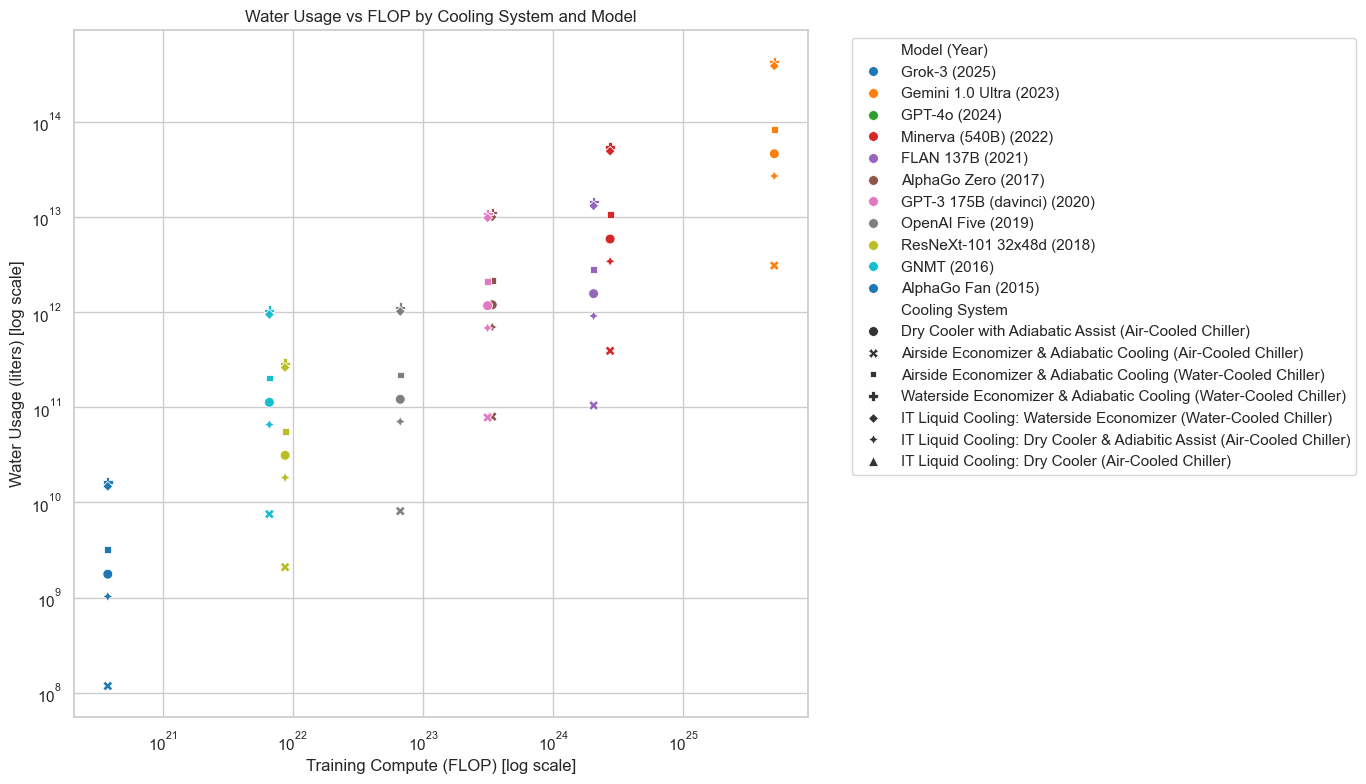

In [301]:
combined_notable = combined_notable.merge(
    final_notable_models[['Model', 'Energy (J)']],
    on='Model',
    how='left'
)

combined_notable['Water Usage'] = combined_notable['AvgWUE'] * combined_notable['Energy (J)']

plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

plot = sns.scatterplot(
    data=combined_notable,
    x='Training compute (FLOP)',
    y='Water Usage',
    hue='Model (Year)',
    style='Cooling System',
    palette=model_color_map,
    s=50
)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Training Compute (FLOP) [log scale]')
plt.ylabel('Water Usage (liters) [log scale]')
plt.title('Water Usage vs FLOP by Cooling System and Model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [302]:
combined_notable['Cooling System Energy (J)'] = combined_notable['Energy (J)'] * (combined_notable['AvgPUE'] - 1)
combined_notable['Total Energy (J)'] = combined_notable['Energy (J)'] + combined_notable['Cooling System Energy (J)']

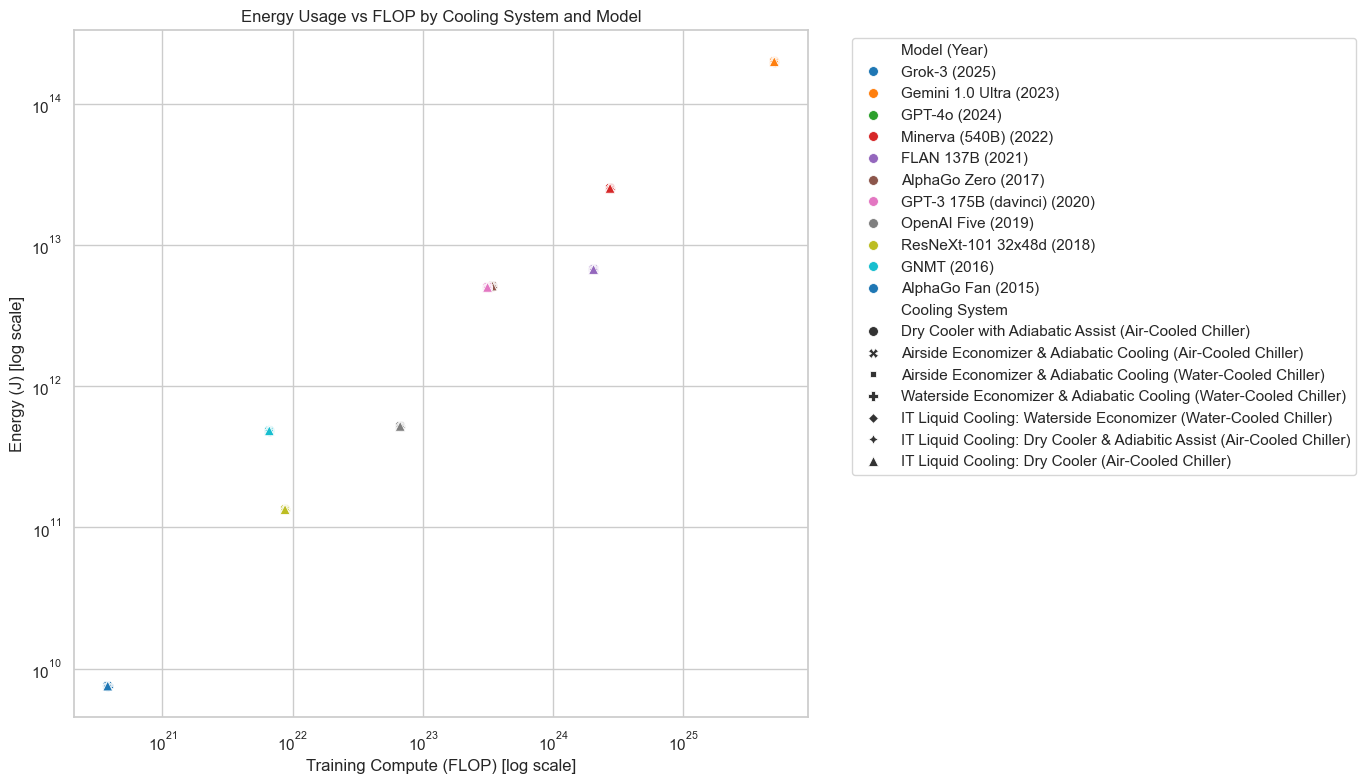

In [303]:
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

plot = sns.scatterplot(
    data=combined_notable,
    x='Training compute (FLOP)',
    y='Energy (J)',
    hue='Model (Year)',
    style='Cooling System',
    palette=model_color_map,
    s=50
)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Training Compute (FLOP) [log scale]')
plt.ylabel('Energy (J) [log scale]')
plt.title('Energy Usage vs FLOP by Cooling System and Model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

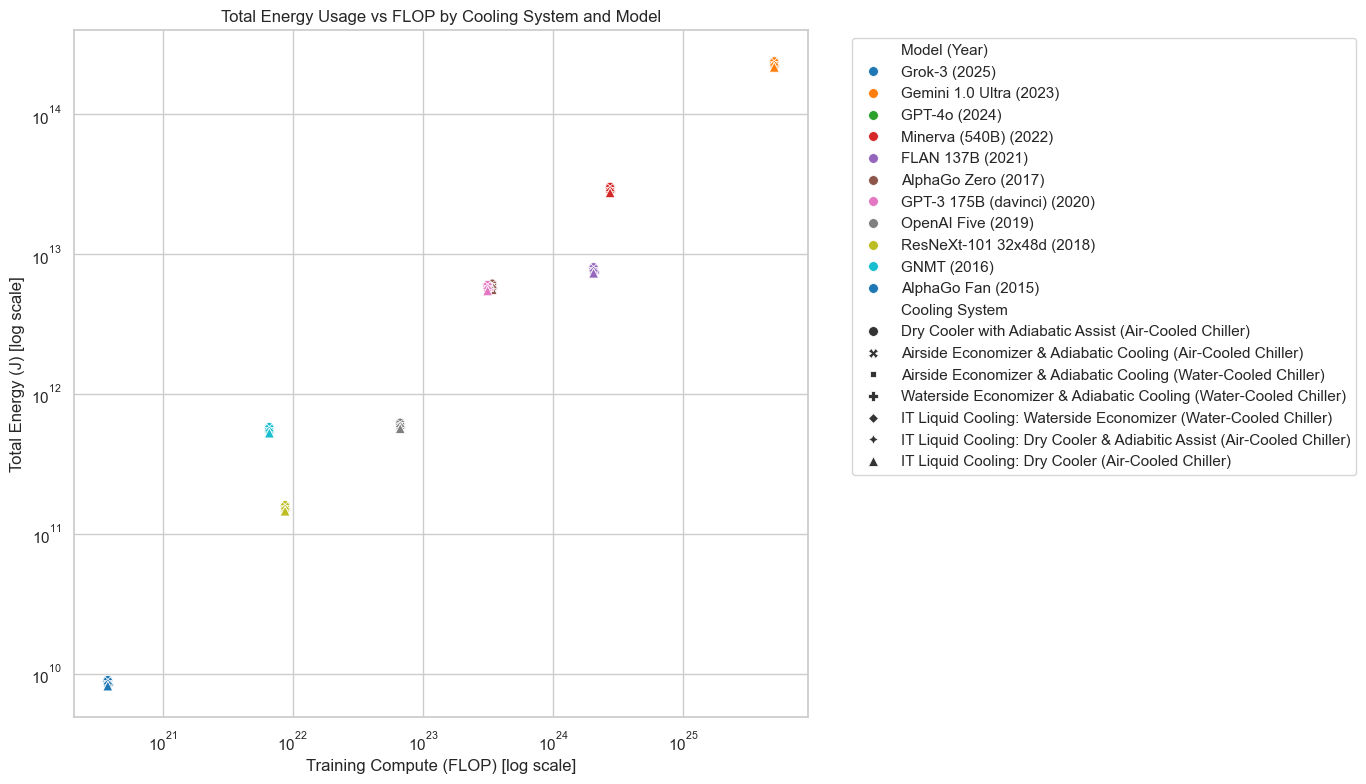

In [304]:
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

plot = sns.scatterplot(
    data=combined_notable,
    x='Training compute (FLOP)',
    y='Total Energy (J)',
    hue='Model (Year)',
    style='Cooling System',
    palette=model_color_map,
    s=50
)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Training Compute (FLOP) [log scale]')
plt.ylabel('Total Energy (J) [log scale]')
plt.title('Total Energy Usage vs FLOP by Cooling System and Model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [305]:
combined_notable['Energy (kWh)'] = combined_notable['Energy (J)'] / (3.6e6)  # Convert Joules to kWh
combined_notable['Cooling System Energy (kWh)'] = combined_notable['Cooling System Energy (J)'] / (3.6e6)  # Convert Joules to kWh
combined_notable['Total Energy (kWh)'] = combined_notable['Total Energy (J)'] / (3.6e6)  # Convert Joules to kWh

combined_notable = pd.merge(combined_notable, carbon_df_usa[['Year', 'Carbon Intensity (kg CO2 per kWh)']], on='Year', how='left')

combined_notable['Carbon Impact (kg CO2)'] = combined_notable['Energy (kWh)'] * combined_notable['Carbon Intensity (kg CO2 per kWh)']
combined_notable['Cooling System Carbon Impact (kg CO2)'] = combined_notable['Cooling System Energy (kWh)'] * combined_notable['Carbon Intensity (kg CO2 per kWh)']
combined_notable['Total Carbon Impact (kg CO2)'] = combined_notable['Total Energy (kWh)'] * combined_notable['Carbon Intensity (kg CO2 per kWh)']

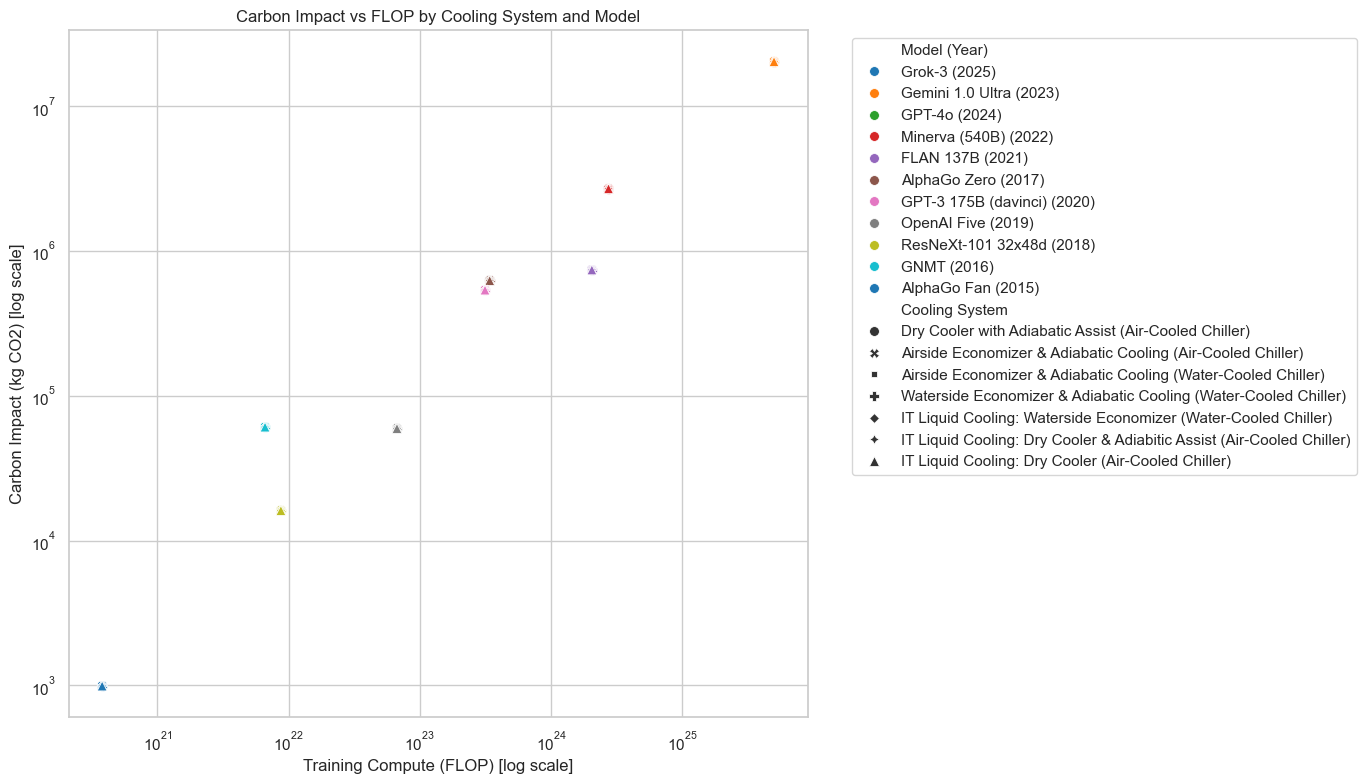

In [306]:
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

plot = sns.scatterplot(
    data=combined_notable,
    x='Training compute (FLOP)',
    y='Carbon Impact (kg CO2)',
    hue='Model (Year)',
    style='Cooling System',
    palette=model_color_map,
    s=50,
)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Training Compute (FLOP) [log scale]')
plt.ylabel('Carbon Impact (kg CO2) [log scale]')
plt.title('Carbon Impact vs FLOP by Cooling System and Model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

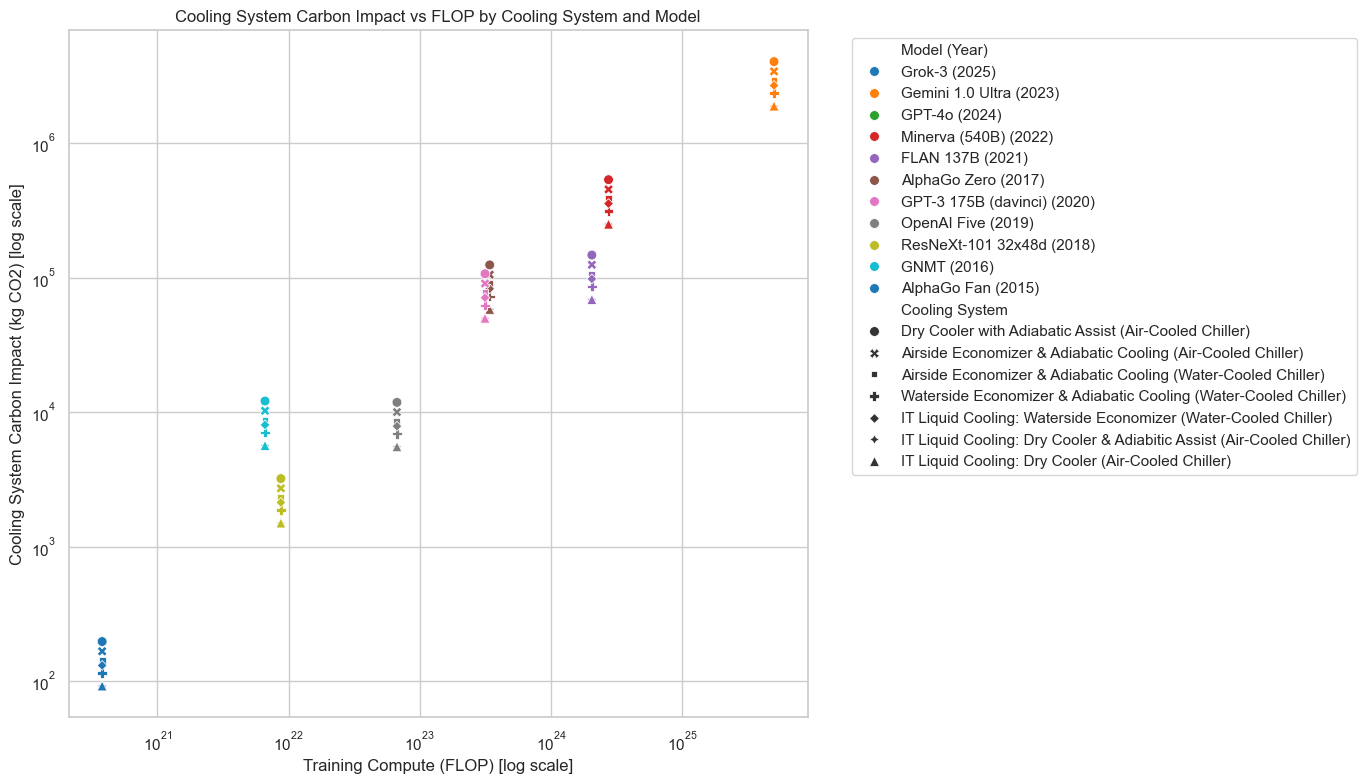

In [307]:
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

plot = sns.scatterplot(
    data=combined_notable,
    x='Training compute (FLOP)',
    y='Cooling System Carbon Impact (kg CO2)',
    hue='Model (Year)',
    style='Cooling System',
    palette=model_color_map,
    s=50,
)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Training Compute (FLOP) [log scale]')
plt.ylabel('Cooling System Carbon Impact (kg CO2) [log scale]')
plt.title('Cooling System Carbon Impact vs FLOP by Cooling System and Model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

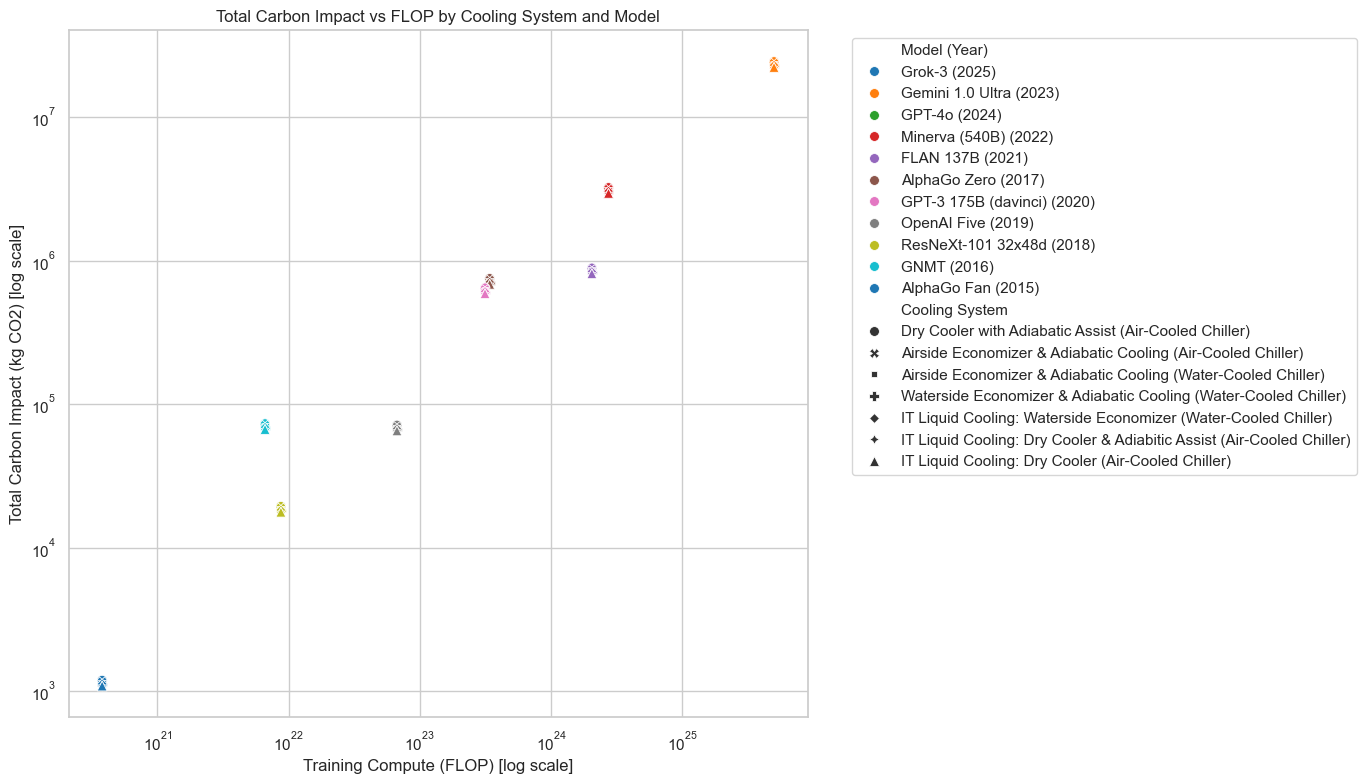

In [308]:
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

plot = sns.scatterplot(
    data=combined_notable,
    x='Training compute (FLOP)',
    y='Total Carbon Impact (kg CO2)',
    hue='Model (Year)',
    style='Cooling System',
    palette=model_color_map,
    s=50,
)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Training Compute (FLOP) [log scale]')
plt.ylabel('Total Carbon Impact (kg CO2) [log scale]')
plt.title('Total Carbon Impact vs FLOP by Cooling System and Model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()